FINETUNE

In [1]:
# --- Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- Install Dependencies ---
!pip install -q transformers datasets accelerate

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import json, torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00


In [3]:
# -------------------- Config --------------------
model_name = "google/bigbird-roberta-base"
train_file = "uoa4_full_trainset_chunked.jsonl"
num_labels = 4
max_length = 4096
device = "cuda" if torch.cuda.is_available() else "cpu"
label_map = {"1": 0, "2": 1, "3": 2, "4": 3}

In [4]:
# -------------------- Load and Map Labels --------------------
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

data = load_jsonl(train_file)
for entry in data:
    entry["label"] = label_map.get(str(entry["label"]).strip(), -1)

In [5]:
# -------------------- Split Dataset --------------------
train_data, eval_data = train_test_split(
    data, test_size=0.1,
    stratify=[d["label"] for d in data],
    random_state=42
)

train_dataset = Dataset.from_list(train_data)
eval_dataset = Dataset.from_list(eval_data)

In [6]:
# -------------------- Tokenization --------------------
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=max_length)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Map:   0%|          | 0/3507 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

In [7]:
# -------------------- Load Model --------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [8]:
# -------------------- Compute Metrics --------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "weighted_f1": f1_score(labels, preds, average="weighted"),
        "macro_precision": precision_score(labels, preds, average="macro"),
        "macro_recall": recall_score(labels, preds, average="macro"),
    }

In [9]:
# -------------------- Training Arguments --------------------
training_args = TrainingArguments(
    output_dir="./uoa4_model",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    eval_strategy="epoch",
    learning_rate=2e-5,
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none",
    save_safetensors=False,
)
# -------------------- Trainer --------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -------------------- Train --------------------
trainer.train()

/tmp/ipython-input-9-3561431544.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall
1,1.375500,1.227053,0.443590,0.287327,0.344670,0.481486,0.360675
2,1.102000,1.154938,0.466667,0.355373,0.424756,0.593720,0.382151
3,0.919300,1.041136,0.551282,0.489466,0.522871,0.568767,0.490514


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1317, training_loss=1.1212573504031564, metrics={'train_runtime': 10263.3617, 'train_samples_per_second': 1.025, 'train_steps_per_second': 0.128, 'total_flos': 2.229863486570496e+16, 'train_loss': 1.1212573504031564, 'epoch': 3.0})

INFERENCE

In [45]:
!pip install -q pymupdf openpyxl seaborn
import os, zipfile, fitz, re
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# -------------------- CONFIG --------------------
top_k = 3
zip_path = "uoa4_testset.zip"
extract_dir = "./uoa4_testset/uoa4_testset"
model_path = "./uoa4_model/checkpoint-1317"
ground_truth_csv = "uoa4_groundtruth.xlsx"
output_csv = "predictions_topk.csv"
max_length = 4096
stride_words = 300
chunk_words = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"
label_map = {0: "1*", 1: "2*", 2: "3*", 3: "4*"}
reverse_label_map = {v: k for k, v in label_map.items()}

In [47]:
# -------------------- PREP --------------------
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

contents = os.listdir(extract_dir)
if len(contents) == 1 and os.path.isdir(os.path.join(extract_dir, contents[0])):
    extract_dir = os.path.join(extract_dir, contents[0])

tokenizer = AutoTokenizer.from_pretrained("google/bigbird-roberta-base")
model.eval()

def clean_text(text):
    text = re.sub(r"\n+", "\n", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"(references|appendix).*", "", text, flags=re.IGNORECASE)
    return text.strip()

def extract_text(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        return clean_text("\n".join([page.get_text() for page in doc]))
    except:
        return ""

def chunk_text(text):
    words = text.split()
    return [
        " ".join(words[i:i + chunk_words])
        for i in range(0, len(words), chunk_words - stride_words)
        if len(words[i:i + chunk_words]) >= 50
    ]

In [48]:
# -------------------- INFERENCE --------------------
results = []
pdf_files = [f for f in os.listdir(extract_dir) if f.lower().endswith(".pdf")]

for fname in pdf_files:
    path = os.path.join(extract_dir, fname)
    text = extract_text(path)

    if not text.strip():
        results.append({"File": fname, "Predicted": "No Text", "Confidence": 0.0, "NumChunks": 0})
        continue

    chunks = chunk_text(text)
    if not chunks:
        results.append({"File": fname, "Predicted": "No Chunks", "Confidence": 0.0, "NumChunks": 0})
        continue

    scored_chunks = []
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            logits = model(**inputs).logits.squeeze(0)
        probs = F.softmax(logits, dim=-1)
        confidence = torch.max(probs).item()
        scored_chunks.append((logits, confidence))

    top_chunks = sorted(scored_chunks, key=lambda x: x[1], reverse=True)[:top_k]
    if not top_chunks:
        results.append({"File": fname, "Predicted": "Uncertain", "Confidence": 0.0, "NumChunks": len(chunks)})
        continue

    avg_logits = sum([logits * conf for logits, conf in top_chunks]) / sum([conf for _, conf in top_chunks])
    probs = F.softmax(avg_logits, dim=-1)
    pred_idx = torch.argmax(probs).item()
    confidence = round(probs[pred_idx].item(), 4)
    label = label_map[pred_idx]

    results.append({"File": fname, "Predicted": label, "Confidence": confidence, "NumChunks": len(chunks)})

 # -------------------- SAVE PREDICTIONS --------------------
df = pd.DataFrame(results)
df["File"] = df["File"].str.lower().str.strip()
df.to_csv(output_csv, index=False)
print(f"✅ Predictions saved to: {output_csv}")

✅ Predictions saved to: predictions_topk.csv



🎯 Accuracy: 46.15%

📊 Classification Report:
               precision    recall  f1-score   support

          1*       1.00      0.33      0.50         9
          2*       0.44      0.80      0.57        10
          3*       0.00      0.00      0.00        10
          4*       0.54      0.70      0.61        10

    accuracy                           0.46        39
   macro avg       0.50      0.46      0.42        39
weighted avg       0.48      0.46      0.42        39

🧮 Macro F1: 0.42
🧮 Weighted F1: 0.418
📉 Skipped or invalid documents: 1


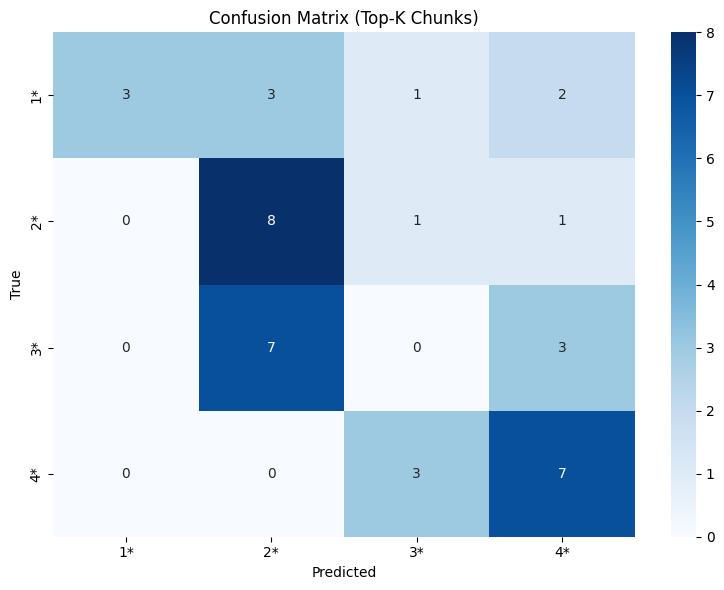

In [49]:
# -------------------- EVALUATION --------------------
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Normalize column names and cases
truth_df = pd.read_excel(ground_truth_csv)
truth_df["PDF_File"] = truth_df["PDF_File"].str.lower().str.strip()
df["File"] = df["File"].str.lower().str.strip()

# Merge predictions with ground truth
merged = pd.merge(df, truth_df, left_on="File", right_on="PDF_File", how="inner")

# Define valid REF labels
valid_labels = ["1*", "2*", "3*", "4*"]

# Convert true labels to string format with asterisk
merged["Assigned_Label_Str"] = merged["Assigned_Label"].astype(str) + "*"

# Filter to include only rows where both predicted and true labels are in valid_labels
merged_filtered = merged[
    merged["Predicted"].isin(valid_labels) &
    merged["Assigned_Label_Str"].isin(valid_labels)
].copy() # Use .copy() to avoid SettingWithCopyWarning

# Convert labels to string consistently
y_true = merged_filtered["Assigned_Label_Str"]
y_pred = merged_filtered["Predicted"]


# Calculate accuracy only on valid predictions
accuracy = (y_true == y_pred).mean()

# Compute metrics safely
conf_matrix = confusion_matrix(y_true, y_pred, labels=valid_labels)
report = classification_report(y_true, y_pred, labels=valid_labels, zero_division=0)
macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
weighted_f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

# -------------------- METRIC OUTPUT --------------------
print(f"\n🎯 Accuracy: {round(accuracy * 100, 2)}%")
print("\n📊 Classification Report:\n", report)
print("🧮 Macro F1:", round(macro_f1, 4))
print("🧮 Weighted F1:", round(weighted_f1, 4))

# Show skipped/invalid docs
# Filter for rows in the original df that are not in the merged_filtered df based on 'File'
skipped_docs = df[~df['File'].isin(merged_filtered['File'])]
print(f"📉 Skipped or invalid documents: {len(skipped_docs)}")


# -------------------- CONFUSION MATRIX --------------------
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=valid_labels, yticklabels=valid_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Top‑K Chunks)")
plt.tight_layout()
plt.show()